In [96]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs

# dask 
from dask.diagnostics import ProgressBar

### plotting 
from matplotlib import pyplot as plt
import palettable


In [2]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 


In [3]:
dpath = pathlib.Path('/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP')

In [4]:
lfiles = list(dpath.glob("GPM_IMERG_daily.v06.????.??.??.nc"))

In [5]:
lfiles.sort()

In [6]:
lfiles[0]

PosixPath('/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP/GPM_IMERG_daily.v06.2001.01.01.nc')

In [7]:
lfiles[-1]

PosixPath('/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP/GPM_IMERG_daily.v06.2021.10.09.nc')

In [8]:
dset = xr.open_mfdataset(lfiles, concat_dim='time', parallel=True)[['precipitationCal']]

In [9]:
climatology = [2001, 2020]

In [11]:
clim = dset.sel(time=slice(*list(map(str, climatology)))) 

### rechunks 

In [12]:
clim = clim.chunk({'time':-1, 'lon':10, 'lat':10})

In [13]:
ndays = 90

### calculates the running accumulation 

In [14]:
clim = clim.rolling({'time':ndays}, min_periods=ndays, center=False).sum('time')

In [15]:
with ProgressBar(): 
    clim = clim.compute()

[########################################] | 100% Completed |  1min  4.5s


In [16]:
clim = clim.isel(time=slice(ndays-1, None))

In [17]:
clim['time'] = clim.indexes['time'].to_datetimeindex()

<ipython-input-17-69a656c69746>:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  clim['time'] = clim.indexes['time'].to_datetimeindex()


In [18]:
clim.time

<xarray.DataArray 'time' (time: 7216)>
array(['2001-03-31T00:00:00.000000000', '2001-04-01T00:00:00.000000000',
       '2001-04-02T00:00:00.000000000', ..., '2020-12-29T00:00:00.000000000',
       '2020-12-30T00:00:00.000000000', '2020-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2001-03-31 2001-04-01 ... 2020-12-31

### compression level 

In [19]:
complevel = 9

In [20]:
clim

<xarray.Dataset>
Dimensions:           (time: 7216, lon: 460, lat: 300)
Coordinates:
  * time              (time) datetime64[ns] 2001-03-31 2001-04-01 ... 2020-12-31
  * lon               (lon) float64 125.1 125.4 125.6 ... 239.4 239.6 239.9
  * lat               (lat) float64 -49.88 -49.62 -49.38 ... 24.38 24.62 24.88
Data variables:
    precipitationCal  (time, lat, lon) float64 326.4 314.4 319.6 ... 3.079 2.987
Attributes:
    BeginDate:       2001-01-01
    BeginTime:       00:00:00.000Z
    EndDate:         2001-01-01
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2001-01-01T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20010101-S000000-E002959.0000.V06...
    title:           GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 d...
    DOI:             10.5067/GPM/IMERGDL/DAY/06
    ProductionTime:  2019-08-08T13:26:06.809Z

In [ ]:
# clim.to_netcdf(f'./GPM_IMERG_daily.v06.{".".join(list(map(str, climatology)))}_precipitationCal_{ndays}d_runsum.nc', encoding=dset.encoding.update({'zlib':True, 'complevel':complevel}))

### get the last N days and calculates the accumulation

In [21]:
last_day = dset.time.to_index()[-1]

In [23]:
last_day = datetime(last_day.year, last_day.month, last_day.day)

In [24]:
last_day

datetime.datetime(2021, 10, 9, 0, 0)

In [25]:
from dateutil.relativedelta import relativedelta

In [26]:
last_day - relativedelta(days=ndays)

datetime.datetime(2021, 7, 11, 0, 0)

In [39]:
dates = pd.date_range(start=last_day - relativedelta(days=ndays - 1), end=last_day, freq='1D')

In [37]:
dset['time'] = (('time'), pd.date_range(start='2001-01-01', end=last_day, freq='1D'))

In [40]:
dset = dset.sel(time=dates)

In [42]:
dset = dset.sum('time')

In [44]:
def calculate_percentileofscore(dset, clim, varname='precipitationCal', timevar='time'): 
    """
    calculates the percentile of score of a dataset given a climatology

    [extended_summary]

    Parameters
    ----------
    dset : xarray.Dataset 
        The input dataset, typically the real time GPM/IMERG dataset 
    clim : xarray.Dataset 
        The climatology (needs to vary along a 'timevar' dimension as well)
    varname : str, optional
        The name of the variable (needs to be the same in both the input and 
        climatological dataset), by default 'precipitationCal'
    timevar : str, optional
        The name of the variable describing the time, by default 'time'

    Returns
    -------
    xarray.Dataset
        The resulting dataset (containing the percentile of score)
    """
    
    
    from scipy.stats import percentileofscore
    import xarray as xr 
    
    try: 
        import dask 
    except ImportError("dask is not available ..."):
        pass 
    
    def _percentileofscore(x, y):
        return percentileofscore(x.ravel(), y.ravel(), kind='weak')
    
    pctscore = xr.apply_ufunc(_percentileofscore, clim[varname], dset[varname], input_core_dims=[[timevar], []],
                vectorize=True, dask='parallelized')

    return pctscore

In [45]:
from scipy.stats import percentileofscore
import xarray as xr 

In [47]:
def _percentileofscore(x, y):
    return percentileofscore(x.ravel(), y.ravel(), kind='weak')

In [48]:
last_day

datetime.datetime(2021, 10, 9, 0, 0)

### checks the number of days in the climatology 

In [52]:
pd.date_range(start='2001-03-31', end='2020-12-31')

DatetimeIndex(['2001-03-31', '2001-04-01', '2001-04-02', '2001-04-03',
               '2001-04-04', '2001-04-05', '2001-04-06', '2001-04-07',
               '2001-04-08', '2001-04-09',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=7216, freq='D')

In [53]:
clim.time

<xarray.DataArray 'time' (time: 7216)>
array(['2001-03-31T00:00:00.000000000', '2001-04-01T00:00:00.000000000',
       '2001-04-02T00:00:00.000000000', ..., '2020-12-29T00:00:00.000000000',
       '2020-12-30T00:00:00.000000000', '2020-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2001-03-31 2001-04-01 ... 2020-12-31

In [54]:
window_clim = 2

In [55]:
dates_clim = [last_day + timedelta(days=shift) for shift in list(range(-window_clim, window_clim+1))]

In [56]:
dates_clim

[datetime.datetime(2021, 10, 7, 0, 0),
 datetime.datetime(2021, 10, 8, 0, 0),
 datetime.datetime(2021, 10, 9, 0, 0),
 datetime.datetime(2021, 10, 10, 0, 0),
 datetime.datetime(2021, 10, 11, 0, 0)]

In [57]:
time_clim = clim.time.to_index()

In [58]:
time_clim = [time_clim[(time_clim.month == d.month) & (time_clim.day == d.day)] for d in dates_clim]

In [60]:
time_clim

[DatetimeIndex(['2001-10-07', '2002-10-07', '2003-10-07', '2004-10-07',
                '2005-10-07', '2006-10-07', '2007-10-07', '2008-10-07',
                '2009-10-07', '2010-10-07', '2011-10-07', '2012-10-07',
                '2013-10-07', '2014-10-07', '2015-10-07', '2016-10-07',
                '2017-10-07', '2018-10-07', '2019-10-07', '2020-10-07'],
               dtype='datetime64[ns]', name='time', freq=None),
 DatetimeIndex(['2001-10-08', '2002-10-08', '2003-10-08', '2004-10-08',
                '2005-10-08', '2006-10-08', '2007-10-08', '2008-10-08',
                '2009-10-08', '2010-10-08', '2011-10-08', '2012-10-08',
                '2013-10-08', '2014-10-08', '2015-10-08', '2016-10-08',
                '2017-10-08', '2018-10-08', '2019-10-08', '2020-10-08'],
               dtype='datetime64[ns]', name='time', freq=None),
 DatetimeIndex(['2001-10-09', '2002-10-09', '2003-10-09', '2004-10-09',
                '2005-10-09', '2006-10-09', '2007-10-09', '2008-10-09',
      

In [61]:
clim_ref = []

for t in time_clim: 

    clim_ref.append(clim.sel(time=t))

clim_ref = xr.concat(clim_ref, dim='time')

#### calculates the anomalies, just for checking ... the patterns and amplitudes are similar to the map generated by the GPM_processing.py script 

In [66]:
varname = 'precipitationCal'

In [72]:
anoms = dset[varname] - clim_ref.mean('time')[varname]

In [97]:
cmap = palettable.colorbrewer.diverging.BrBG_11.mpl_colormap

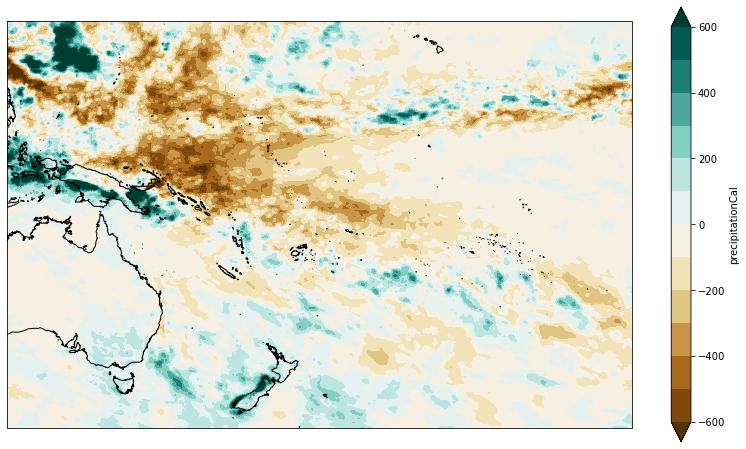

In [98]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), figsize=(14,8))
anoms.plot.contourf(ax=ax, cmap=cmap, transform=ccrs.PlateCarree(), levels=np.arange(-600, 700, 100))
ax.coastlines(resolution='10m')

### now calculates the percentile of scores 

In [85]:
pctscore = xr.apply_ufunc(_percentileofscore, clim_ref[varname], dset[varname], input_core_dims=[['time'], []],
            vectorize=True, dask='parallelized')

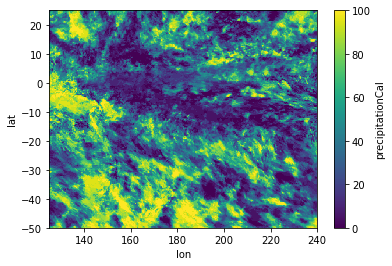

In [89]:
pctscore.plot()

### reads the percentage of scores calculated in GPM_processing.py 

In [90]:
pctscore_ops = xr.open_dataset('./pctscore.nc') 

In [91]:
pctscore_ops

<xarray.Dataset>
Dimensions:   (time: 1, lat: 300, lon: 460)
Coordinates:
  * time      (time) datetime64[ns] 2021-10-09
  * lat       (lat) float64 -49.88 -49.62 -49.38 -49.12 ... 24.38 24.62 24.88
  * lon       (lon) float64 125.1 125.4 125.6 125.9 ... 239.1 239.4 239.6 239.9
Data variables:
    pctscore  (time, lat, lon) float64 ...
Attributes:
    BeginDate:       2021-07-12
    BeginTime:       00:00:00.000Z
    EndDate:         2021-07-12
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2021-07-12T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20210712-S000000-E002959.0000.V06...
    title:           GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 d...
    DOI:             10.5067/GPM/IMERGDL/DAY/06
    ProductionTime:  2021-07-13T14:44:24.073Z
    ndays:           90
    last_day:        2021-10-09

In [93]:
pctscore = pctscore.to_dataset(name='pctscore')

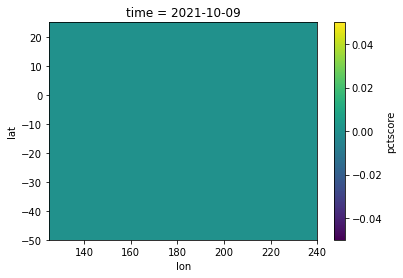

In [95]:
(pctscore - pctscore_ops)['pctscore'].squeeze().plot()